## TP3 Regresión lineal

In [81]:
%env OMP_NUM_THREADS=2
%env MKL_NUM_THREADS=2

env: OMP_NUM_THREADS=2
env: MKL_NUM_THREADS=2


In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans
#from sklearn.model_selection import train_test_split
#from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin

#### 1. Carga de datos

In [83]:
np.random.seed(42)

X_all = np.loadtxt("datasets/dataset-2-training-Entradas.txt")
t_all = np.loadtxt("datasets/dataset-2-training-targets.txt")
X_unknown = np.loadtxt("datasets/dataset-2-Entradas.txt")

# Asegurar columna
if X_all.ndim == 1:
    X_all = X_all.reshape(-1, 1)
if t_all.ndim == 1:
    t_all = t_all.reshape(-1, 1)
if X_unknown.ndim == 1:
    X_unknown = X_unknown.reshape(-1, 1)

$$ x \in \mathbb{R}; \quad t \in \mathbb{R} $$ 

####  División de los datos en entrenamiento y validación

In [84]:
n_train = 400
X_train = X_all[:n_train]
t_train = t_all[:n_train]
X_val = X_all[n_train:]
t_val = t_all[n_train:]

print("Shapes:", X_train.shape, t_train.shape, X_val.shape, t_val.shape)

Shapes: (400, 1) (400, 1) (100, 1) (100, 1)


#### RBF

In [85]:
class RBFTransformer(BaseEstimator, TransformerMixin):
    """
    Transforma x -> [1, exp(-||x - mu_j||^2 / (2 sigma^2)) for j=1..M]
    Selecciona centros con KMeans en fit.
    """
    def __init__(self, n_centers=10, sigma=None, random_state=None):
        self.n_centers = n_centers
        self.sigma = sigma
        self.random_state = random_state
        self.centers_ = None
        self.sigma_ = None
    
    def fit(self, X, y=None):
        # KMeans para centros
        n_centers = min(self.n_centers, len(X))
        if n_centers <= 0:
            raise ValueError("n_centers must be >=1")
        km = KMeans(n_clusters=n_centers, random_state=self.random_state)
        km.fit(X)
        self.centers_ = km.cluster_centers_
        
        # si sigma no se provee, estimar como media de distancias entre centros
        if self.sigma is None:
            if n_centers > 1:
                dists = []
                for i in range(n_centers):
                    for j in range(i+1, n_centers):
                        dists.append(np.linalg.norm(self.centers_[i] - self.centers_[j]))
                mean_dist = np.mean(dists) if len(dists)>0 else 1.0
                self.sigma_ = max(mean_dist, 1e-6)
            else:
                self.sigma_ = 1.0
        else:
            self.sigma_ = self.sigma
        return self
    
    def transform(self, X):
        N = X.shape[0]
        M = self.centers_.shape[0]
        Phi = np.ones((N, 1 + M))  # bias + M rbf
        for j in range(M):
            diff = X - self.centers_[j]  # diffs componente a componente
            sq_dist = np.sum(diff**2, axis=1, keepdims=True)
            Phi[:, j+1:j+2] = np.exp(-sq_dist / (2 * (self.sigma_**2)))
        return Phi

# --------------------------
# Funciones auxiliares
# --------------------------
def mse(y, t):
    return np.mean((y - t)**2)

def fit_ridge_on_features(Phi_train, t_train, alpha=1e-3):
    # Resolvemos Ridge con closed form usando sklearn para robustez
    model = Ridge(alpha=alpha, fit_intercept=False, solver='auto')  # Phi incluye bias
    model.fit(Phi_train, t_train.ravel())
    w = model.coef_.reshape(-1,1)  # (M+1,1)
    # sklearn Ridge with fit_intercept=False stores coef_ as 1d; intercept in intercept_
    return model, w

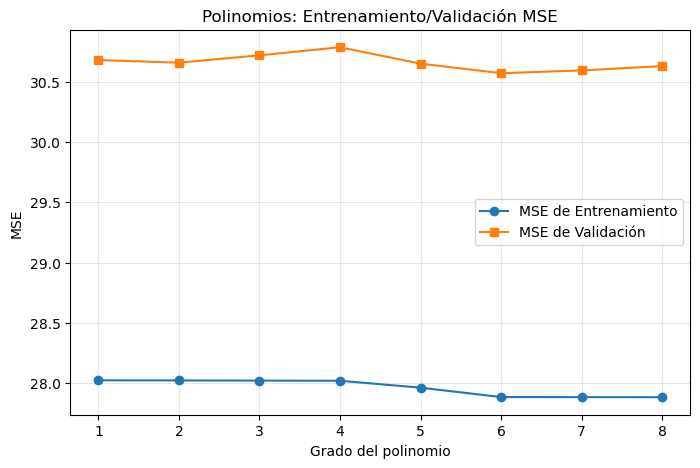

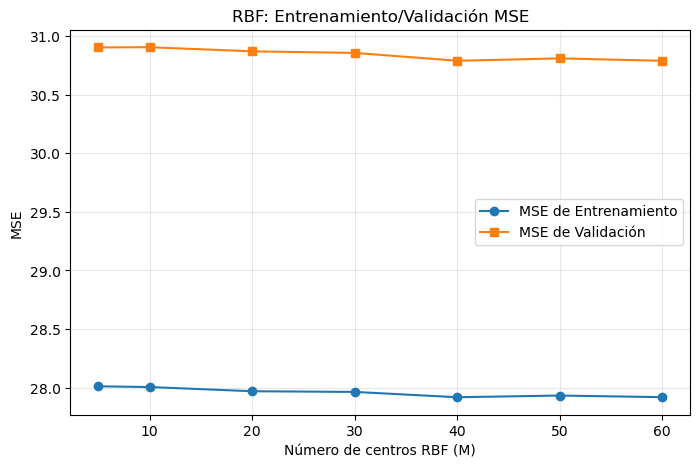

In [86]:
# --------------------------
# Experimentos: polinomio y RBF
# --------------------------
alph = 1e-3  # regularización (lambda)
degrees = [1,2,3,4,5,6,7,8]
train_mse_poly = []
val_mse_poly = []

# --- Polinomial pipeline manual (scaler + poly) ---
for deg in degrees:
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X_train)
    poly = PolynomialFeatures(degree=deg, include_bias=True)
    Phi_train = poly.fit_transform(Xs)  # incluye columna de 1s
    
    # resolver con Ridge (solución equivalente a (Phi^T Phi + alpha I) w = Phi^T t)
    ridge = Ridge(alpha=alph, fit_intercept=False, solver='auto')
    ridge.fit(Phi_train, t_train.ravel())
    
    # predicciones
    Phi_val = poly.transform(scaler.transform(X_val))
    y_train = ridge.predict(Phi_train).reshape(-1,1)
    y_val = ridge.predict(Phi_val).reshape(-1,1)
    
    train_mse_poly.append(mse(y_train, t_train))
    val_mse_poly.append(mse(y_val, t_val))

# Graficar errores polinomiales
plt.figure(figsize=(8,5))
plt.plot(degrees, train_mse_poly, 'o-', label='MSE de Entrenamiento')
plt.plot(degrees, val_mse_poly, 's-', label='MSE de Validación')
plt.xlabel("Grado del polinomio")
plt.ylabel("MSE")
plt.title("Polinomios: Entrenamiento/Validación MSE")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- RBF experiments ---
M_list = [5, 10, 20, 30, 40, 50, 60]
train_mse_rbf = []
val_mse_rbf = []
rbf_models = {}

for M in M_list:
    # fit transformer
    rbf = RBFTransformer(n_centers=M, random_state=42)
    Phi_train = rbf.fit(X_train).transform(X_train)
    
    ridge = Ridge(alpha=alph, fit_intercept=False, solver='auto')
    ridge.fit(Phi_train, t_train.ravel())
    
    Phi_val = rbf.transform(X_val)
    y_train = ridge.predict(Phi_train).reshape(-1,1)
    y_val = ridge.predict(Phi_val).reshape(-1,1)
    
    train_mse_rbf.append(mse(y_train, t_train))
    val_mse_rbf.append(mse(y_val, t_val))
    rbf_models[M] = (rbf, ridge)

# Graficar errores RBF
plt.figure(figsize=(8,5))
plt.plot(M_list, train_mse_rbf, 'o-', label='MSE de Entrenamiento')
plt.plot(M_list, val_mse_rbf, 's-', label='MSE de Validación')
plt.xlabel("Número de centros RBF (M)")
plt.ylabel("MSE")
plt.title("RBF: Entrenamiento/Validación MSE")
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

#### Selección del mejor modelo (mejor validación MSE entre polinomio y rbf)

In [87]:
best_poly_deg = degrees[int(np.argmin(val_mse_poly))]
best_poly_val = min(val_mse_poly)
best_rbf_M = M_list[int(np.argmin(val_mse_rbf))]
best_rbf_val = min(val_mse_rbf)

print("Mejor polynomial degree:", best_poly_deg, "Val MSE:", best_poly_val)
print("Mejor RBF M:", best_rbf_M, "Val MSE:", best_rbf_val)

if best_poly_val <= best_rbf_val:
    chosen = ('poly', best_poly_deg)
else:
    chosen = ('rbf', best_rbf_M)
print("MODELO ELEGIDO:", chosen)

Mejor polynomial degree: 6 Val MSE: 30.57453659825627
Mejor RBF M: 60 Val MSE: 30.78857040789227
MODELO ELEGIDO: ('poly', 6)


#### Entrenamiento final con todos los datos y predicción de desconocidos

In [88]:
if chosen[0] == 'poly':
    scaler_final = StandardScaler().fit(X_all)
    poly_final = PolynomialFeatures(degree=chosen[1], include_bias=True)
    Phi_all = poly_final.fit_transform(scaler_final.transform(X_all))
    ridge_final = Ridge(alpha=alph, fit_intercept=False).fit(Phi_all, t_all.ravel())
    Phi_unknown = poly_final.transform(scaler_final.transform(X_unknown))
    y_unknown = ridge_final.predict(Phi_unknown).reshape(-1,1)
else:
    rbf_final = RBFTransformer(n_centers=chosen[1], random_state=42).fit(X_all)
    Phi_all = rbf_final.transform(X_all)
    ridge_final = Ridge(alpha=alph, fit_intercept=False).fit(Phi_all, t_all.ravel())
    Phi_unknown = rbf_final.transform(X_unknown)
    y_unknown = ridge_final.predict(Phi_unknown).reshape(-1,1)

np.savetxt("predicciones_unknown_sklearn.txt", y_unknown, fmt="%.6f")
print("Predicciones guardadas en 'predicciones_unknown_sklearn.txt' (primeras 5):")
print(y_unknown[:5].flatten())

Predicciones guardadas en 'predicciones_unknown_sklearn.txt' (primeras 5):
[0.17087598 0.28643618 0.37950415 0.44194649 0.51569911]


Varianza ruido estimada sigma^2 = 28.339834731597634


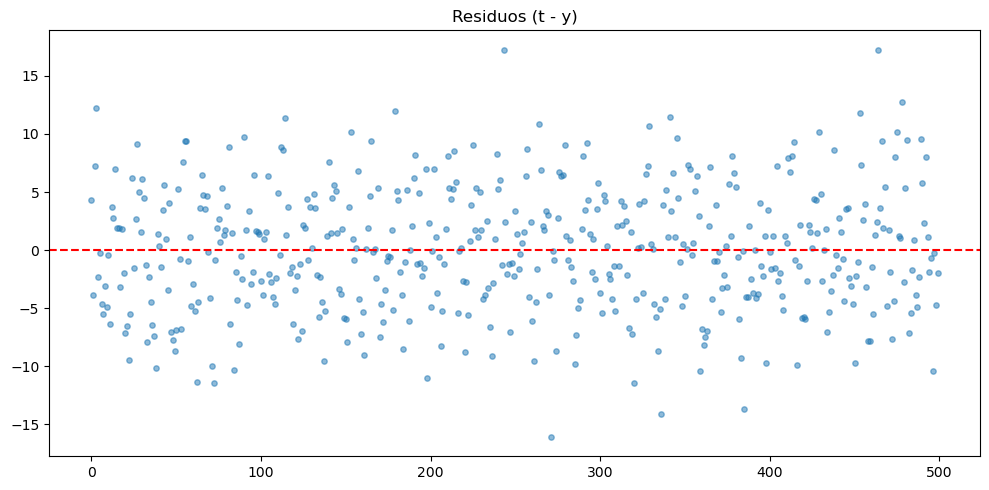

In [89]:
y_all = ridge_final.predict(Phi_all).reshape(-1,1)
residuals = t_all - y_all
sigma2_hat = np.var(residuals)  # estimación de varianza del ruido
print("Varianza ruido estimada sigma^2 =", sigma2_hat)

# Graficar residuos y su histograma
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(residuals)), residuals, s=15, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.title("Residuos (t - y)")
plt.tight_layout(); plt.show()

Se puede ver que la varianza se mantiene constante

#### Distribución predictiva para la primera muestra desconocida

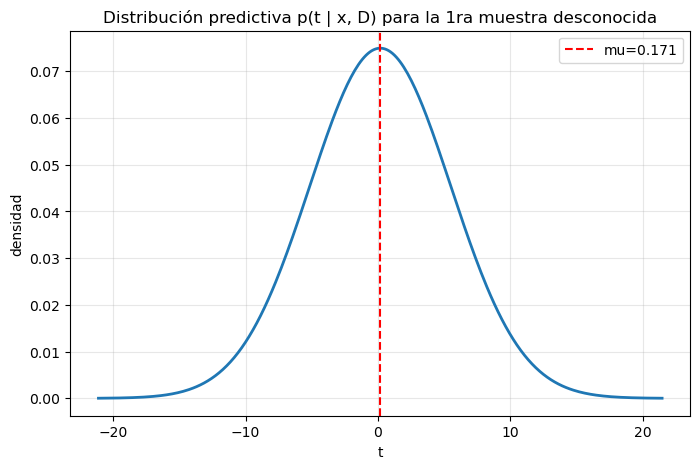

In [90]:
if np.asarray(sigma2_hat).size == 1 and np.asarray(sigma2_hat).item() > 0:
    mu = np.asarray(y_unknown).ravel()[0].item()  # o np.squeeze(y_unknown).item()
    std = np.sqrt(np.asarray(sigma2_hat).item())
    xs = np.linspace(mu - 4*std, mu + 4*std, 300)
    pdf = (1/(std*np.sqrt(2*np.pi))) * np.exp(-0.5*((xs-mu)/std)**2)
    plt.figure(figsize=(8,5))
    plt.plot(xs, pdf, linewidth=2)
    plt.axvline(mu, color='r', linestyle='--', label=f"mu={mu:.3f}")
    plt.title("Distribución predictiva p(t | x, D) para la 1ra muestra desconocida")
    plt.xlabel("t"); plt.ylabel("densidad"); plt.legend(); plt.grid(True, alpha=0.3); plt.show()